# Classification
See
- https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb,
- https://en.wikipedia.org/wiki/MNIST_database, and
- http://yann.lecun.com/exdb/mnist/.

## MNIST
page 79<br>
"MNIST database" stands for "Modified National Institute of Standards and Technology database".

In [1]:
# First, let's set up some basics as shown on github (see link above)!
# common imports
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# Now, let's continue with the code from the book!
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

According to the above cell, the data contains 70000 rows (instances), each with 784 columns (features). The features represent the 28x28=784 pixel structure. Each pixel has some value on the grey scale, between 0 (white) and 255 (black). The following cell shows that each instance has only one target attribute. Namely the digit that the data shall represent.

In [3]:
y.shape

(70000,)

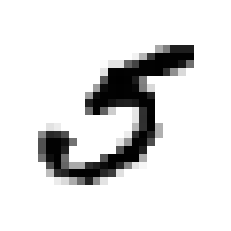

In [4]:
# Here, some part is missing as it has already been run in the first cell (setting up some basics).
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
# visualize the data of row 36000
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
# the above picture looks like a "5"
y[36000]

5.0

Seems to match. All this makes sense so far. Before getting more into the data, we should separate the test set.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# The data should be shuffled because for some algorithms, the order matters in the sense that they
# perform poorly if they get many similar instances in a row.
# Again, some part is missing as it has already been run in the first cell (setting up some basics).
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier
page 82<br>
Here, the goal is to only determine whether a data instance represents a "5" or not (true or false).

In [7]:
y_train_5 = (y_train == 5)      # yields "true" if the instance of y_train is a "5" and "false" if it is not
y_test_5 = (y_test == 5)        # the same for y_test
# We use a stochastic gradient descent classifier. This classifier relies on randomness. Setting the random
# seed to "42" should lead to identical results for consecutive runs.
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) # the labels are "true" for all fives and "false" for all other instances
sgd_clf.predict([some_digit])   # try the trained model on the digit chosen (and plotted) above

array([ True])

That seems to work fine. At least for this digit. Now let's learn about how a classification algorithm's performance can be measured.
## Performance Measures
page 82
### Measuring Accuracy Using Cross-Validation
page 83<br>
The main part of this subsection resumes after the following excursion (framed by horizontal lines).
___
#### Implementing Cross-Validation
excursion on page 83<br>
Scikit-Learn has the function "cross_val_score()" for cross-validation. But in certain settings, more control than offered by this function might be required. In that case, it makes sense to use an own function for cross-validation. The following function does basically the same as Scikit-Learn's "cross_val_score()" function, yet it can be adopted if necessary.

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)            # using 3 folds
for train_index, test_index in skfolds.split(X_train, y_train_5): # there are 3 folds, so the loop will run 3 times
    clone_clf = clone(sgd_clf)                                    # clone the classifier for each run
    X_train_folds = X_train[train_index]                          # determine all the data for the current fold
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)                   # train the model
    y_pred =  clone_clf.predict(X_test_fold)                      # make the predictions for this test fold
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))                                # score = correct / total (for this fold)

0.9613
0.9635
0.9661


These ratios of correct predictions are the same ratios as those obtained next via Scikit-Learn's cross_val_score() function.

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9613, 0.9635, 0.9661])

The "accuracy"-scorings are all above 95%. That sounds incredibly good. However, it should be noted that just by always predicting "not a 5", one would get 90% simply because about 90% of the digts are not 5s. Only about 10% of the digits are 5s. Let's confirm that with a trivial classifier, that always predicts "not a 5".

In [10]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass                                     # doesn't do any training
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # simply returs boolean zeros (false) for everything
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

As expected, the accuracy is about 90%.
### Confusion Matrix
page 84<br>
As we  have just seen, a quantitative measure for the performance of classifiers can be rather unintuitive. One very useful way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classfier confused images of 5s with 3s, one would look in the 5th row and 3rd column of the confusion matrix.

In [11]:
# To examine predictions with the confusion matrix, we should first have some predictions. These are made here.
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # makes predictions on 3 folds
# Now, let's look at the confusion matrix!
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54122,   457],
       [ 1725,  3696]])

Different columns correspond to different predictions and different rows correspond to different labels. 54122 instances have been correctly classified as non-5s ("true negative" where "true" means correct classification and "negative" refers to the predicted class). 1725 instances have been wrongly classified as 5s, although they are not 5s ("false positive": the classfication is incorrect and the prediction is "positive"). This first row represents the "negative class" (easy to remember: +1(-1)=-1(+1)=-1 i.e. negative).<br>
457 instances have been wrongly classified as non-5s, although they are actually 5s ("false negative") and 3696 instances have been correctly classified as 5s ("true positive"). This second row represents the "positive class" (analog: (+1)(+1)=(-1)(-1)=+1 i.e. positive).

In [12]:
# A perfect classifier would only have zeros as off-diagonal elements.
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The "precision" of a classifier is defined as<br><br>$$\frac{TP}{TP+FP},$$<br>where $TP$ stands for "true positive" (other matrix elements analog). Note that unit precision can be achieved by classifying all instances as non-5s but one single instant, which certainly represents a 5. Despite unit precision, this classifier might not be very useful. The classifier's "recall" is<br><br>$$\frac{TP}{TP+FN}.$$<br>A trivial classifier that predicts all instances as being 5s will have $FN=0$, $TP>0$, and hence unit recall. Still, this classifier is of no use.
### Precision and Recall
page 86

In [13]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # should be 4344/(4344+1307)
print(4344/(4344+1307))
print(recall_score(y_train_5, y_train_pred))     # should be 4344/(4344+1077)
print(4344/(4344+1077))

0.8899590657356128
0.7687135020350381
0.6817930271167681
0.801328168234643


The 5-detector "cross_val_predict" is much better than guessing but still, its 5-predictions have only 80% actual 5s. And of all 5s, it classifies less thant 77% correctly as 5s. The $F_1$ score,<br><br>
$$F_1=\frac{2}{\frac{1}{\rm{precision}}+\frac{1}{\rm{recall}}}=\frac{2}{\frac{\rm{TP}+\rm{FP}}{\rm{TP}}+\frac{\rm{TP}+\rm{FN}}{\rm{TP}}}=\frac{2\rm{TP}}{2\rm{TP}+\rm{FP}+\rm{FN}},$$<br>
combines both precision and recall in one single score between 0 (precision is 0 and/or recall is 0) and 1 (both are 1).

In [14]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7720910800083559

The $F_1$ score favors classifiers where both precision and recall are lagre. However, depending on the application, a high recall (e.g., for indicating shoplifters) or a high precision (e.g., for marking media content as safe for kids) might be more important than the other.
### Precision/Recall Tradeoff
page 87<br>
Classifiers use to have a scoring function that maps an instance's features to a number. If that score is higher than a certain threshold, the instance is predicted to belong to the "true"-class (e.g. "true, it's a 5"). If the score is below that threshold, the instance is predicted to belong to the "false"-class ("false, it's not a 5"). Scikit does not let us set the threshold directly but it grants access to the scores. This way, we can still set a threshold and then classify the instances by means of our own code.

In [15]:
y_scores = sgd_clf.decision_function([some_digit])  # taking the score of some_digit
print(y_scores)                                     # printing the score
threshold = 0                                       # setting our own threshold
y_some_digit_pred = (y_scores > threshold)          # translating the score to a binary output
print(y_some_digit_pred)                            # printing the output

[5220.50278623]
[ True]


In [16]:
# "threshold = 0" is actually the threshold of the classifier, let's check another threshold
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

That went as expexted. Now, let's get the scores of all instances by returning these instead of the predictions. Then, we can use the function "precision_recall_curve()" to get the precision and the recall as a function of the threshold. 

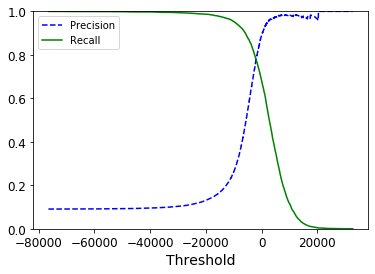

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") # getting the scores
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)               # applying the function
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):                    # defining the plot
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)                         # making the plot
plt.show()

Note that "recall" is a monotone function while "precision" is not! This has to do with the fact that "recall" only deals with those instances that are actual 5s. As the threshold increases, the number of actual 5s does not change and the number of those that are classified as 5s can only decrease. Yet "precision" deals only with those instances that are predicted to be 5s. As the threshold is increased, the number of predicted 5s will decrease. Every time a "true positive" instance drops out while the number of "false positives" remains unchanged, the precision will shortly drop (while the overall trend will improve, unless the classifier is really, really bad).

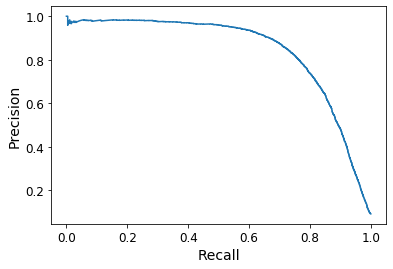

In [18]:
# As recall is a monotone function of the threshold, it can also be useful to plot the precision against the
# recall. This corresponds to the above plot, yet with the x-axis reversed (recall decreases with increasing
# threshold) and rescaled.
def plot_precision_vs_recall(precisions, recalls):                    # defining the plot
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
plot_precision_vs_recall(precisions, recalls)                         # making the plot
plt.show()

In [19]:
# According to the plot before the one above, we should get a precision of about 90% once the threshold exceeds
# 70000 (see the book). Let's check that!
y_train_pred_90 = (y_scores > 70000)               # vector with "true" for all scores that are greater than 70000
print(precision_score(y_train_5, y_train_pred_90)) # show precision (it's actually a bit below 90%...)
print(recall_score(y_train_5, y_train_pred_90))    # show recall

0.0
0.0


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Lesson learned: you always need to consider precision AND recall, because one compromises the other.
### The ROC Curve
page 91<br>
The "receiver operating characteristic" (ROC) curve plots the "true positive rate" (TPR) versus the "false positive rate" (FPR). The TPR is given by<br><br>
$${\rm TPR}={\rm sensitivity}={\rm recall}=\frac{\rm TP}{\rm TP+FN},$$<br>
The "false positive rate",<br><br>
$${\rm FPR}=\frac{\rm FP}{\rm FP+TN}=1-{\rm specifity},$$<br>
is 1-TNR, where "TNR" stands for the "true negative rate" or "specifity", ${\rm TN/(FP+TN)}$. The "precision" is ${\rm TP/(TP+FP)}$ and until now, we have not heard of a corresponding name for negative predictions ${\rm TN/(TN+FN)}$. The "accuracy" is ${\rm (TN+TP)/(T+P)}$, where ${\rm T=TP+FN}$ and ${\rm P}$ likewise. Details can be found on https://en.wikipedia.org/wiki/Precision_and_recall.

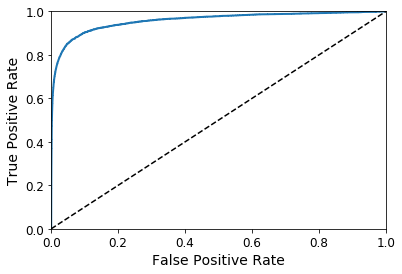

In [20]:
# let's import the relevant function from Scikit-Learn so we can plot the ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

As for precision and recall, there is a tradeoff also for the ROC-curve: the higher the true positive rate the higher is also the false positive rate. This can be understood from the formulas above: the nominators are constant as they represent the number of instances that belong to the positive and negative class, respectively. Lowering the threshold (going to the right in the plot) will increase both ${\rm TP}$ and ${\rm FP}$. Still, different algorithm are going to perform differently, i.e., one better than another.
<br> Good performance means large TPR at low FPR. Due to the above argument the curve must have a monotone behavior. So a rather straightforward measure for performance will be the area under the curve for the receiver operator curve ("ROC AUC"). A perfect classifier will have ${\rm ROC AUC = 1}$ and a purely random classifier will have ${\rm ROC AUC = 1/2}$.

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9577210519742373

Note:<br>
The "recall vs. precision" curve further above and the ROC curve look very similar. The former should be used if the positive class is rare or whenever avoidance of false positives is a priority. Otherwise, the ROC should be used. The reasoning goes as follows:
- If the positive class is rare, the negative class will be abundant. In that case, the precision ${\rm TP/(TP+FP)}$ is a good score since only a good algorithm will avoid classifying a lot of actual negatives as positive. In short, it will be hard to keep ${\rm FP}$ small and the precision will be large exactly when ${\rm FP}$ is small compared to ${\rm TP}$.
- In the negative class is small, one should simply exchange the classification labels and, following the above argument, also use the "recall vs. precision" curve.
- If neither class is small, a good algorithm is expected to keep both ${\rm FP}$ and ${\rm FN}$ small at the same time. So the TPR should be large at small FPR. The ROC curve allows to read this off easily.

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


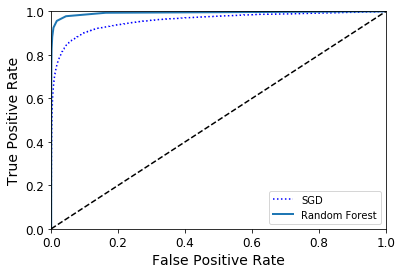

In [22]:
# Let's train a RandomForestClassifier to compare its ROC with the one above. Scikit-Learn classsifier ususally
# have either a decision_function() method or a predict_proba() method. The RandomForestClassifier has the latter.
# The predict_proba() method returns a row per instance and a row per class (here "True" or "False") that contains
# the probability, i.e., a scalar quantity similar to the values returned by the decision_function() method.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") # scalars in rows
y_scores_forest = y_probas_forest[:, 1] # use the probability for "True"
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest) # as for the previous classifier
# adding the according graph to the already exisiting plot
plt.plot(fpr, tpr, "b:", label="SGD") # this changes the line style of the previous graph
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [23]:
# The RandomForestClassifier's ROC curve looks much better. This is confirmed by the AUC.
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [24]:
# computing recall and precision for the RandomForestClassifier
y_pred_forest = y_scores_forest > 0.5
forest_confuse = confusion_matrix(y_train_5, y_pred_forest)
print(forest_confuse)
TN = forest_confuse[0,0]
FP = forest_confuse[0,1]
FN = forest_confuse[1,0]
TP = forest_confuse[1,1]
print("recall:    ",100*TP/(TP+FN),"%")
print("precision: ",100*TP/(TP+FP),"%")

[[54512    67]
 [  931  4490]]
recall:     82.82604685482383 %
precision:  98.52973447443493 %


## Multiclass Classification
page 93<br>
So far, we have only considered a binary classifiers that distinguishes between N=2 classes ("true" and "false"). Multiclass classifcation uses N>2 classes. For example the classification of the digits 0 through 9 requires N=10 classes.
- One possibility to do that is to train 10 binary classes, each of which is dedicated to one out of the 10 classes and outputs a score/probability that the instance belongs to the class. Then an instance will be classified according to the classifier that gives the highest output on that instance. This is called one-versus-all (OvA) multiclass classifcation.
- Another possibility is to train N(N-1)/2 binary classifiers, each of which compares a different pair of classes. The class that wins most one-versus-one (OvO) matches will be predicted for that instance.

OvA requires N classifiers and thus usually less than OvO, which requires N(N-1)/2 classifiers to be trained. However, OvA requires training on all N classes whereas OvO requires training of each algorithm on only 2 classes. OvA is usually more time-efficient. Yet, if an algorithm scales poorly on larger training sets - and training on all classes implies larger training sets for OvA - OvO might be the better choice.<br>
In the following example, ScikitLearn detects that the target set (labels) has N>2 classes and thus automatically runs OvA.

In [25]:
sgd_clf.fit(X_train, y_train) # now we use y_train (10 classes) instead of y_train_5 (2 classes)
sgd_clf.predict([some_digit]) # the classification is correct, cf. this output and "some_digit" above

array([5.])

In [26]:
# look what scores the decision function has assigned to each of the 10 classes
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
# indeed, the score of "5" (6th column due to start with "0") has the highest score
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

[[ -8204.47519778 -19206.28224706  -5702.10113982  -4666.3653033
  -15827.7809826    1782.52380291 -39807.3747045  -18945.8333413
  -14650.34384565 -16166.06981109]]
5
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
5.0


Note:<br>
When a classifier is trained, it stores the list of target classes in its classes\_ attribute, ordered by value. In this case, the index of each class in the classes\_ array conveniently matches the class itslef (e.g., the class at index 5 happens to be class 5), but in general we will not be so lucky.

In [27]:
# Enforcing OvO or OvA is possible with the according classes provided by ScikitLearn. Here is an example.
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit])) # prediction
print(len(ovo_clf.estimators_))      # number of classifers (or estimators) is 45=N(N-1)/2 for N=10

[5.]
45


In [28]:
# training a random forest classifier is just as easy
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5.])

In [29]:
# The above classifier did not have to decide between OvO or OvA because it can handle N>2 classes directly,
# i.e., without having to employ binary classifiers as explained above (just below "Multiclass Classification").
# Let's look at the probabilities that the classifier assigned to each of the classes.
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [30]:
# One also should evaluate the classifiers on their performance. At best via cross-validation, as this makes best
# use of the training data. Let's do that!
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86762647, 0.88469423, 0.8306746 ])

In [31]:
# All runs reach more than 84% whereas a random classifier would only get 10% as for each instance there is a
# chance of 10% (there are 10 classes) that the random classifier happens to make the correct prediction. And
# without much ado, this score can be improved even by only scaling the input features to zero mean and unit
# standard deviation.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") # Already, we get more than 90%!

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89982004, 0.90534527, 0.90153523])

## Error Analysis
page 96<br>
For a real project it would be wise to follow the Machine Learning project checklist (see Appendix B in the book):
- exploring data preparation options,
- trying out multiple models, 
- shortlisting the best models and fine-tuning their hyperparameters using GridSearchCV, and
- automating as much as possible.

This is not a real project so let's assume we have zeroed in on a certain model and now we want to optimize it. To this end, looking at the failures made by the model seems to be a good idea. This is possible by the confusion matrix (as already introduced above).

In [32]:
# via cross_val_predict, we get predictions on the entire training set, i.e. 60000
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) 
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5597,    0,   15,    9,   10,   43,   36,    5,  207,    1],
       [   1, 6419,   41,   22,    3,   45,    4,    8,  186,   13],
       [  23,   25, 5267,   91,   71,   27,   64,   45,  334,   11],
       [  30,   20,  113, 5277,    2,  202,   26,   45,  349,   67],
       [  10,   18,   39,   11, 5254,    9,   39,   21,  280,  161],
       [  30,   20,   26,  158,   53, 4499,   75,   21,  476,   63],
       [  28,   18,   43,    5,   37,   96, 5552,    7,  132,    0],
       [  20,   10,   55,   27,   48,   11,    4, 5721,  160,  209],
       [  19,   71,   39,  111,    1,  127,   28,   10, 5398,   47],
       [  24,   23,   29,   60,  126,   34,    1,  188,  314, 5150]])

<function matplotlib.pyplot.show(*args, **kw)>

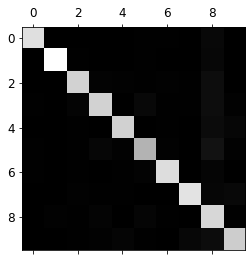

In [33]:
# That's a lot of numbers! Visualization helps humans in efficient interpretation.
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]
[60000]


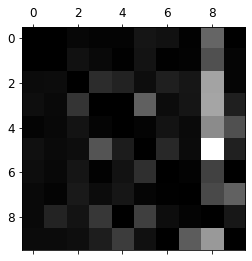

In [34]:
# This looks quite good, although the 5s are a bit darker than the other numbers on the diagonal (see numeric
# output above). To compare the error rates, each matrix element should be divided by the total number of instances
# in the actual class (rows).
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)
print(sum(row_sums))
norm_conf_mx = conf_mx / row_sums
# To resolve the errors (off-diagonal elements) better, we put the diagnoal elements to 0.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Apparently, the columns (i.e. predictions!) for 8s and 9s are quite bright. So there seems to be a lot of misclassification that should be taken care of by improving the classifier for 8s and 9s. Possibly, this could be resolved by counting the number of closed loops per image (1 loop for 9s and 2 loops for 8s. Rows 0 and 1 arerather dark, so no further actions might be required for these. Note that the matrix is not symmetric: more 5s are predicted to be 8s than 8s are predicted to be 5s. Also, 7s tend to be confused with 9s and vice versa. The same also applies for 3s and 5s. These digits mainly differ by the position of the vertical connection in the upper part of the digit: it is on the left for 5s and on the right for 3s. Some digits are drawn at the edge of their square and some seem to be somewhat rotated. So, a possible ansatz is to rotate each image to some conventional direction and to center it within its square. This would likely not only improve the classification of 3s and 5s but of all digits.

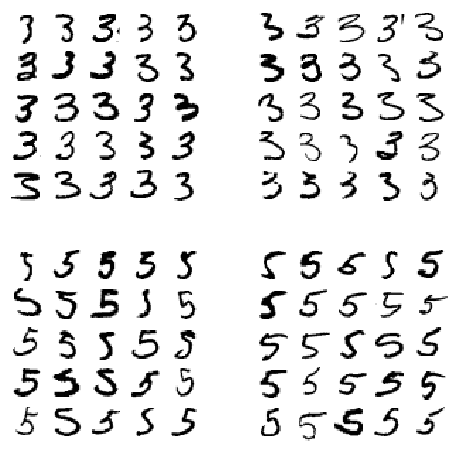

In [35]:
# These confusions will not be resolved, now. However, as a first step, we plot examples of correctly and
# incorrectly classified 3s and 5s.
# extra function taken from the above link to github
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # actual 3s classified as 3s
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # actual 3s classified as 5s
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # actual 5s classified as 3s
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # actual 5s classified as 5s
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The 6th digit in the first row really looks more like a 5 than like a 3. And the first digit in the 8th row can be easily interpreted as a 3. Still, most of these instances will be easily classified correctly by a human. That's because humans have really fancy data preprocessing routines and exceptional pattern detection capabilities. This model, on the other hand, is only some very basic model that has not been optimized in many respects.
## Multilabel Classification
page 100<br>
It is possible to assign more than one class to each instance. This is called multilabel classification. For example, a face-recognition classifier could work with N classes, 1 for each of N persons that may be on a photo or not. For the digits 0 through 9, one of the many possibilities is to assign a class "≥7" and a class "odd". This will be done in the following. 

In [36]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = ( y_train >= 7)                  # ≥7
y_train_odd = (y_train % 2 ==1)                  # odd
y_multilabel = np.c_[y_train_large, y_train_odd] # both labels combined in one multilabel
knn_clf = KNeighborsClassifier()                 # Not all classifiers support multilabel classification but this ...
                                                 # ... one does. So we use it.
knn_clf.fit(X_train, y_multilabel)               # train the classifier
knn_clf.predict([some_digit])                    # make predictions on our heavily used instance, which is a 5)

array([[False,  True]])

There are endless possibilities as to how a multilabel classifier can be evaluated. Here, we use the $F_1$ score, apply it to each individual label, and then take the average to get a single scalar quantity between 0 and 1.

In [37]:
# WARNING: this cell takes about an hour!
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3) # predictions on the entire training set
f1_score(y_multilabel, y_train_knn_pred, average="macro")                  # calculating the averaged F1 score
# Note that "y_multilabel" needs to be used instead of "y_train" and "y_label" (see also github link)!

0.97709078477525

Using the average assumes that both labels are equally important. Depending on the situation, this might not be appropriate. One rather simple option is to give each label a weight equal to its _support_ (i.e., the number of instances with that target label). This can be achieved by using average="weighted" instead of average="macro" in the above code.
## Multioutput Classification
page 101<br>
Multioutput classification combines multilabel classification and multiclass classification. Now, each label can be a multiclass. This can be illustrated by the 28x28=784 pixels of each MNIST digit. Each pixel has a value between 0 and 255. Each pixel is associated with a label (i.e., 784 labels) and each label is classified into one out of 256 classes, namely the value of the pixel (between 0 and 255).<br><br>
Note:<br>
The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification. Moreover, multioutput systems are not limited to classification tasks; you could even have a system that outputs multiple labels per instance, including both class labels and value labels.<br><br>
In the following, the task is to remove random noise from the MNIST images.

In [38]:
noise = np.random.randint(0, 100, (len(X_train), 784)) # Make some noise!
X_train_mod = X_train + noise                          # Add the noise to the training data.
noise = np. random.randint(0, 100, (len(X_test), 784)) # Make some more noooooise!
X_test_mod = X_test + noise                            # Add the noooooise to the test data.
y_train_mod = X_train                                  # Use the clean original data as the target labels.
y_test_mod = X_test                                    # Also use the clean, original data as the test labels.

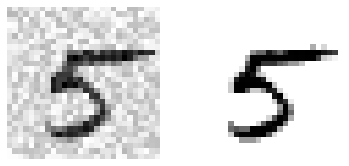

In [39]:
# additional code taken from the link to github above
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
# saving the figure has been removed, here (in contrast to the github code)
plt.show()

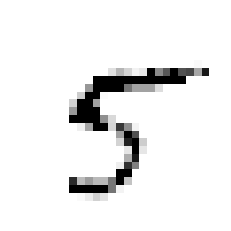

In [40]:
knn_clf.fit(X_train_mod, y_train_mod)                   # train the model with noisy input and clean labels
clean_digit = knn_clf.predict([X_test_mod[some_index]]) # prediction should have less noise
plot_digit(clean_digit)                                 # indeed, there is less noise than in the input image

## Extra Material
see github link above
### Dummy (i.e. Random) Classifier

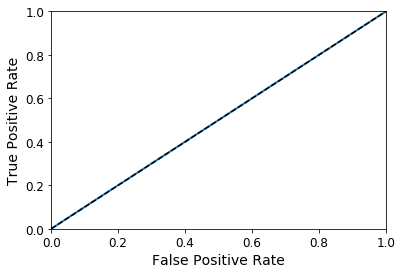

In [41]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba") # make "predictions"
y_scores_dmy = y_probas_dmy[:, 1] # take the probabilities from the "true" class (i.e., "yes, it's a 5")
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy) # create the data for the ROC curve
plot_roc_curve(fprr, tprr)                                   # plot the ROC curve

As mentioned in the subsection "The ROC curve", a random classifier is expected to have an ROC curve that lies on the TPR=FPR line. The dummy (random) classifier confirms this expectation.
### KNN Classifier

In [42]:
from sklearn.neighbors import KNeighborsClassifier                           # import the classifier class
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4) # specify the classifier
knn_clf.fit(X_train, y_train)                                                # train the classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [43]:
y_knn_pred = knn_clf.predict(X_test)       # make predictions
from sklearn.metrics import accuracy_score # chechk the accuracy of the predictions
accuracy_score(y_test, y_knn_pred)

0.9714

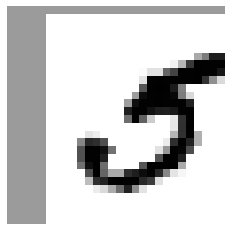

In [44]:
# Now, the digits shall be shifted by a certain number of pixels in the x- and/or y-direction.
from scipy.ndimage.interpolation import shift      # import the shift fucntion

def shift_digit(digit_array, dx, dy, new=0):       # define a function to use that shift for the MNIST digits
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100)) # plot a shifted MNIST digit

In [45]:
# Now, we add 4 total training sets to the original training data, thus augmenting the data.
X_train_expanded = [X_train] # original training instances
y_train_expanded = [y_train] # training labels
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)): # 4 different shifts on the original training data
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy) # shift the training data
    X_train_expanded.append(shifted_images)       # append the shifted training data
    y_train_expanded.append(y_train)              # append the training labels (unchanged)

X_train_expanded = np.concatenate(X_train_expanded) # charming shape
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape      # as expected, the data has now 5 times the original length

((300000, 784), (300000,))

In [46]:
knn_clf.fit(X_train_expanded, y_train_expanded) # training the classifier on the augmented data
y_knn_expanded_pred = knn_clf.predict(X_test)   # making predictions
print(y_knn_expanded_pred)
accuracy_score(y_test, y_knn_expanded_pred)     # checking the accuracy

[0. 0. 0. ... 9. 9. 9.]


0.9763

Apparently, the accuracy increased only by about 0.5%, from 97.1% further above (using the default data set) to not 97.6% (using the augmented data set). But note that the residual percentage has been cut from 2.9% to 2.4%, i.e., by about 16%! This is a large step.

In [47]:
# The accuracy is above 97%. That's quite good but still leaves room to improve. The following digit is predicted
# to be a 2 with a probability just slightly above 50%. The predicted probability for it to be a 7 is almost the
# same at just below 50%.
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.       , 0.       , 0.5053645, 0.       , 0.       , 0.       ,
        0.       , 0.4946355, 0.       , 0.       ]])

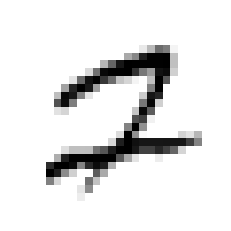

In [48]:
# When plotting that ambiguous digit, even a human could not clearly identify it as a 2 or a 7.
plot_digit(ambiguous_digit)

## Exercises
page 102
### 1.
Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighorsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid searh on the "weights" and "n\_neighbors" hyperparameters).

In [49]:
from sklearn.model_selection import GridSearchCV                 # importing grid search
# Use the original parameter set only when there is enough time (> 1 day)!
# param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
param_grid = [{'weights': ["distance"], 'n_neighbors': [4]}]     # parameter grid for grid search
knn_clf = KNeighborsClassifier()                                 # build a classifier
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3) # grid search with the knn classifier
grid_search.fit(X_train, y_train)                                # make predictions

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_neighbors=4, weights=distance .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... n_neighbors=4, weights=distance, score=0.971, total=16.0min
[CV] n_neighbors=4, weights=distance .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.0min remaining:    0.0s


[CV] ..... n_neighbors=4, weights=distance, score=0.973, total=16.0min
[CV] n_neighbors=4, weights=distance .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 32.0min remaining:    0.0s


[CV] ..... n_neighbors=4, weights=distance, score=0.975, total=16.0min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.975, total=16.0min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.972, total=16.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 80.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': [4], 'weights': ['distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [50]:
print(grid_search.best_params_) # show the best parameter set
print(grid_search.best_score_)  # and the best score

{'n_neighbors': 4, 'weights': 'distance'}
0.97325


In [51]:
from sklearn.metrics import accuracy_score # import the accuracy score (accuracy has been defined above)
y_pred = grid_search.predict(X_test)       # make predictions on the test set
accuracy_score(y_test, y_pred)             # check the predictions on the test set with the test labels

0.9714

### 2.
Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observ that your model perfomrs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_.

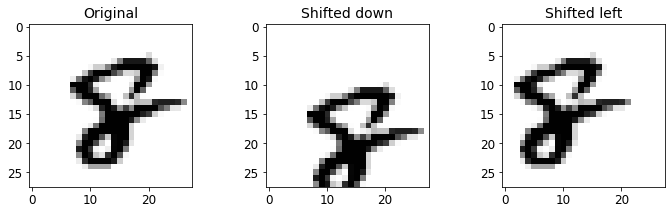

In [52]:
from scipy.ndimage.interpolation import shift  # import the "shift" function from scipy
def shift_image(image, dx, dy):              # this function shifts the images by [dx, dy] pixels
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])
image = X_train[1000]                          # original
shifted_image_down = shift_image(image, 0, 5)  # shift down
shifted_image_left = shift_image(image, -5, 0) # shift left
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")              # plot original
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys") # plot shift down
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys") # plot shift left
plt.show()

In [53]:
X_train_augmented = [image for image in X_train]    # X_train_augmented is basically the same as X_train
y_train_augmented = [label for label in y_train]    # y_train_augmented is basically the same as y_train
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):   # perform shifts by 1 pixel in all directions
    for image, label in zip(X_train, y_train):      # for every original instance and label, append ...
        X_train_augmented.append(shift_image(image, dx, dy)) # ... the augmented instances and ...
        y_train_augmented.append(label)             # ... the augmented (unchanged) labels 
X_train_augmented = np.array(X_train_augmented)     # turn X_train_augmented into a numpy array
y_train_augmented = np.array(y_train_augmented)     # turn y_train_augmented into a numpy array

In [54]:
shuffle_idx = np.random.permutation(len(X_train_augmented))      # make random permutations and apply them ...
X_train_augmented = X_train_augmented[shuffle_idx]               # ... to the instances and ...
y_train_augmented = y_train_augmented[shuffle_idx]               # ... to the labels
from sklearn.model_selection import GridSearchCV                 # importing grid search
# The commented code would take very long to run. Instead, the best paramters "grid_search.best_params_"
# are taken manually from exercise 1.
## Use the original parameter set only when there is enough time (> 1 day)!
## param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
#param_grid = [{'weights': ["distance"], 'n_neighbors': [4]}]               # parameter grid for grid search
#grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)           # grid search with the knn classifier
# knn_clf = KNeighborsClassifier(**grid_search.best_params_)                # build a classifier
knn_clf = KNeighborsClassifier(**{'n_neighbors': 4, 'weights': 'distance'}) # build a classifier
knn_clf.fit(X_train_augmented, y_train_augmented)                # train the classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [55]:
from sklearn.metrics import accuracy_score # import the accuracy score (accuracy has been defined above)
y_pred = knn_clf.predict(X_test)           # make predictions
accuracy_score(y_test, y_pred)             # check the accuracy of the predictions

0.9763

The improvement is 0.5%. This is great when taking into account that there is not much room for improvement left, see the comment in the subsection "KNN Classifier" above.
### 3.
Tackle  the _Titanic_ dataset. A great place to start is on Kaggle (https://www.kaggle.com/c/titanic).

In [56]:
# import the data
import os
TITANIC_PATH = os.path.join("datasets", "chapter3", "Titanic")
import pandas as pd
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    print(csv_path)
    return pd.read_csv(csv_path)
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")
train_data[:5]

datasets/chapter3/Titanic/train.csv
datasets/chapter3/Titanic/test.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The training data (above) contains all features as well as the labels ("Survived"). In contrast, the test data (below) only contains the features, not the labels. This is on purpose, to avoid snooping. When we are happy with our model, we can make predictions on the test set and submit / upload our predicitons to the kaggle competition to see how our model actually performs.

In [57]:
test_data[:5]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The attributes have the following meanings:
- PassengerID: numbering; probably useless
- Survived: target label
- Pclass: passenger class
- Name: self-explanatory
- Sex: self-explanatory
- Age: self-explanatory
- SibSp: sum of siblings and spouses aboard
- Parch: sum of children and parents aboard
- Ticket: ticket ID
- Fare: ticket price (in pounds)
- Cabin: cabin number
- Embarked: place of embarkment

In [58]:
# get an overview over the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The **Age**, **Cabin**, and **Embarked** attributes are incomplete (less than 891). Compared to the other attributes, the *cabin* attribute is particularly sparse. So we will not consider this one for now. The *Age* attribute is missing the feature for about 19% of instances. We will fill the missing features with the median value. The **Name** and **Ticket** attributes may have some useful value but this is going to be difficult to quantify. So we will ignore them.<br><br>
Let's have a look at the numerical attributes.

In [59]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Ouch, only 38% survived! :(<br>
This is close to 40% so **accuracy** might be a good metric.<br>
(We have introduced the *accuracy* in the context of the receiver operating characteristic (ROC) curve. We did not point out that it would be good around 40%. But, assuming that Aurélon Géron is correct - see link to Github above - this seems to be the case.)
- The mean fare was 32.20£. That does not sound expensive but surely was a lot of money back in 1912.
- The mean age was below 30.

Let's check what values apply for the target label!

In [60]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

We should also check the categorical attributes.

In [61]:
print(train_data["Pclass"].value_counts())
print(train_data["Sex"].value_counts())
print(train_data["Embarked"].value_counts())

3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


The **Embarked** feature tells us where the passenger has boarded the Titanic: *S = Southamption, C = Cherbourg, and Q = Queenstown*.<br><br>
Now, we will define a class, that allows us to handle the categorical attributes with **one-hot encoding** (see the *Housing* project in chapter 2). This is a bit complicated so we just copy the following cell from the github link above. But something like this is said to be added to Scikit-Learn.

In [62]:
# own preliminary
import numpy as np
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, no need to try to
# understand every line.
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64, handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown
    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)
        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)
        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")
        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape
        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]
        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))
        self.categories_ = [le.classes_ for le in self._label_encoders_]
        return self
    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)
        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])
            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])
        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)
        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)
        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32), n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]
        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]), dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

Now, we handle the preprocessing.

In [63]:
# this establishes a pipeline for numerical attributes
# import more stuff and establish a class
from sklearn.base import BaseEstimator, TransformerMixin
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
# build the pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", Imputer(strategy="median")),
    ])
# check the pipeline
num_pipeline.fit_transform(train_data)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [64]:
# this establishes a pipeline for categorical attributes
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent)
# build the pipeline
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
    ])
# check the pipeline
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [65]:
# complete data preparation
# combine both pipelines into one
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
# apply the combined pipeline to the training data
X_train = preprocess_pipeline.fit_transform(train_data)
print(X_train)
# establish the labels for training (just give it a name)
y_train = train_data["Survived"]

[[22.  1.  0. ...  0.  0.  1.]
 [38.  1.  0. ...  1.  0.  0.]
 [26.  0.  0. ...  0.  0.  1.]
 ...
 [28.  1.  2. ...  0.  0.  1.]
 [26.  0.  0. ...  1.  0.  0.]
 [32.  0.  0. ...  0.  1.  0.]]


Select, train and apply a classifier.

In [66]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [67]:
# make predictions
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)
# check the percentage of correct predictions using cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
scores.mean()

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default 

0.7365250822835092

About 73% is better than guessing but not good enough for us! Let's try another model!

In [68]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
scores.mean()

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

0.8115690614005221

Now, we get 81%. We can settle with that. Now, let's look at the survival probabilities depending on age and relatives on board.

In [69]:
# age in steps of 15 (0-15, 15-30, 30-45, 45-60, 60-75, 75+)
train_data["AgeBucket"] = train_data["Age"] // 15 * 15 # category with "floor of age/15" times 15; 0, 15, 30, ...
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean() # group by age bucket and take the mean of
# both categories (affects "Survived" but not "AgeBucket" because the values are all the same in the latter)

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [70]:
# both siblings as well as parents and children are relatives
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


### 4.
Build a spam classifier (a more challenging exercise):
- Download examples of spam and ham from Apache SpamAssassin's public datasets (https://spamassassin.apache.org/old/publiccorpus/).
- Unzip the datasets and familiarize yourself with the data format.
- Split the datasets into a training set and a test set.
- Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector indicating the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello", "how", "are", "you", then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning ["Hello" is present "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.
- You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with "URL", replace all numbers with "NUMBER", or even perfrom *stemming* (i.e., trim off word endings; there are Python libraries available to do this).
- Then try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.

In [71]:
# relevant imports
import os
import tarfile
from six.moves import urllib
# download paths and target path on own computer
DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "chapter3", "spam")
# defining a function for fetching and saving the data
def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()
# fetching and saving the data
fetch_spam_data()
# put spam and ham in separate directories
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]   # sort and avoid system files
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20] # sort and avoid system files
# check number of instances for both classes
print(len(ham_filenames))
print(len(spam_filenames))

2500
500


Using Python's email module to handle headings, encoding and so on.

In [72]:
import email
import email.policy
def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]
print(ham_emails[1].get_content().strip())  # show an example instance (first ham)
print("\n_____new_email_below_____\n")
print(spam_emails[6].get_content().strip()) # show an example instance (sixth spam)

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/

_____new_email_below_____

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a 

Some emails consist of several parts, containing images, attachements, possibly attachements with their own attachements and so on. So here, we look at this structure of emails.

In [73]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([get_email_structure(sub_email) for sub_email in payload]))
    else:
        return email.get_content_type()
from collections import Counter
def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

The above output shows the most common structure of ham emails and the below output does the same for spam emails. It seems that spam has typically more HTML while ham has usually more plain text. This is just one example. Obviously, all this is part of "exploring the data".

In [74]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

Below, we look at the email header. In this example, the sender ("From : 12a1mailbot1@web.de") seems questionable. However, we will just focus on the subject line, here.

In [75]:
# header
for header, value in spam_emails[0].items():
    print(header,":",value)
# subject line
print()
print(spam_emails[0]["Subject"])

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

Very important before we investigate the data further: split the data into training and test sets!

In [76]:
# usual imports and definitions of variables
import numpy as np
from sklearn.model_selection import train_test_split
X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, we start preprocessing the data. Here, this involves conversion of all emails to plain text.

In [77]:
# define a function that converts HTML to plain text
import re
from html import unescape
def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)
# check some HTML spam
html_spam_emails = [email for email in X_train[y_train==1] if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")
# now try the above function out on that HTML spam (convert to plain text)
print("\n___plain_text_below___")
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

Now, try to convert any email to HTML, whatever its format is.

In [78]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Let's make use of *stemming*, i.e., of identifying the stems of words in the message (see output for clarification).<br>
See the github link at the top of this code for an instruction on how to install the necessary software.

In [79]:
try:
    import nltk
    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Error: stemming requires the NLTK module.


Testing *urlextract* (see github link above for details).

In [80]:
try:
    import urlextract # may require an Internet connection to download root domain names
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


Now, define a data transforming function that turns an instance (an email) into counts of word stems.

In [81]:
# import more stuff
from sklearn.base import BaseEstimator, TransformerMixin
# define a class that has a "transform" function (or method)
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)
# apply the transformer to a few emails
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christianity': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'one': 2, 'on': 2, 'been': 2, 'has': 2, 'half': 2, 'jesus': 2, 'some': 1, 'interesting': 1, 'quotes': 1, 'http': 1, 'www': 1, 'postfun': 1, 'com': 1, 'pfp': 1, 'worbois': 1, 'html': 1, 'thomas': 1, 'examined': 1, 'known': 1, 'superstitions': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'superstition': 1, 'redeeming': 1, 'feature': 1, 'they': 1, 'are': 1, 'alike': 1, 'founded': 1, 'fables': 1, 'mythology': 1, 'millions': 1, 'innocent': 1, 'men': 1, 'women': 1, 'children': 1, 'since': 1, 'introduction': 1, 'burnt': 1, 'tortured': 1, 'fined': 1, 'imprisoned': 1, 'what': 1, 'effect': 1, 'this': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fools': 1, 'other': 1, 'hypocrites': 1, 'support': 1, 'roguery': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1

That looks good. The above word counts shall be converted to vectors. This is done with the following transformer (defined within a new class).

In [82]:
# more imports
from scipy.sparse import csr_matrix
# definition of class and new transformer
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))
# application of the new transformer on the previous output
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

The relevant vocabulary consists of the 10 words (or word stems). The 3 row of the sparse matrix correspond to the 3 emails in question, here. Each row has 11 columns, the first showing the count of words that do not occur in the relevant vocabulary and the following 10 rows showing the counts of the according vocabulary. E.g., the word "the" occurs 65 times in the third email and the word "by" occurs 3 times in the second email, see below.

In [83]:
print(vocab_transformer.vocabulary_)
print(X_few_vectors.toarray())

{'the': 1, 'of': 2, 'and': 3, 'to': 4, 'http': 5, 'NUMBER': 6, 'com': 7, 'all': 8, 'yahoo': 9, 'in': 10}
[[  6   0   0   0   0   0   0   0   0   0   0]
 [112  11   9   8   3   1   0   1   3   0   1]
 [ 92   0   1   2   3   4   5   3   1   4   2]]


Now, we put all that stuff into one pipeline, apply that pipeline to the training data, train a logistic regressor on the processed training data, and see how the regressor performs.

In [84]:
# import stuff
from sklearn.pipeline import Pipeline
# establish pipeline
preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])
# apply pipeline to the entire training data
X_train_transformed = preprocess_pipeline.fit_transform(X_train)
# import even more stuff
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
# establish a logistic regressor, train it, and see how it scores
log_clf = LogisticRegression()
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV]  ................................................................
[CV] .................................... , score=0.981, total=   0.5s
[CV]  ................................................................
[CV] .................................... , score=0.983, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] .................................... , score=0.993, total=   0.4s


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


0.9854166666666667

For 3-fold cross-validation, we get 98.5% right. That looks promising but note that this is only a small dataset. Probably, the current code will not perform as good on a larger, more difficult dataset. But here, we only wanted to outline the big picture and this should be clear now. To finish this off, let's check precision, $TP/(TP+FP)$, and recall, $TP/(TP+FN)$!

In [85]:
from sklearn.metrics import precision_score, recall_score
X_test_transformed = preprocess_pipeline.transform(X_test)
log_clf = LogisticRegression()
log_clf.fit(X_train_transformed, y_train)
y_pred = log_clf.predict(X_test_transformed)
print("Precision: {:.2f}%".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred)))

Precision: 0.99%
Recall: 0.98%
